In [8]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
from dateutil.relativedelta import relativedelta
import csv 
import pmdarima as pm
from datetime import date, timedelta

In [9]:
client_name = 'test' #name of whoever you're running the information 
training_set = 'data/first_half.csv' #what you'll be training the model on 
confirmation_set = 'data/second_half.csv' #what you'll be using to confirm the model 
metric = 'clicks' #metric that you are running on
columnname = 'clicks'#column that you are running the prediction on
columntime = 'date'
days_in_year=365
dateformat = 'days'

          clicks
date            
3/2/2020   31451
3/3/2020   30945
3/4/2020   31029
3/5/2020   30604
3/6/2020   30446


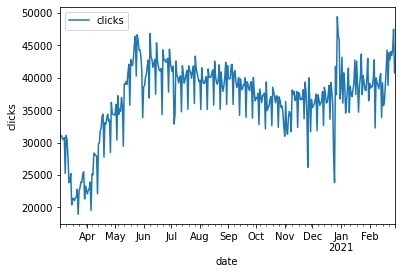

In [10]:
series = pd.read_csv(training_set, index_col=0, usecols=[columntime, columnname])
print(series.head())

series.index = pd.to_datetime(series.index)

# line plot of dataset
series.plot()
plt.ylabel(metric)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  364
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -3424.832
Date:                Mon, 04 Apr 2022   AIC                           6857.664
Time:                        22:37:29   BIC                           6873.242
Sample:                             0   HQIC                          6863.856
                                - 364                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8388      0.039    -21.531      0.000      -0.915      -0.762
ma.L1          0.2208      0.040      5.575      0.000       0.143       0.298
ma.L2         -0.6933      0.030    -22.974      0.0

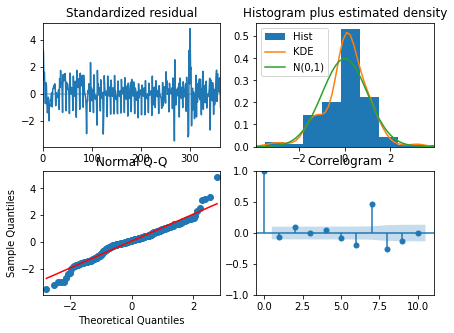

In [12]:
model = pm.auto_arima(series[columnname], 
                      test='adf',       # uses the adfuller tes
                      m=1,              # determine frequency of series, keep at 1
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality - set to true for SARIMA
                      start_P=0, 
                      D=0, 
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

model.plot_diagnostics(figsize=(7,5))
plt.show()

In [13]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

          clicks
date            
3/2/2021   43558
3/3/2021   42866
3/4/2021   42920
3/5/2021   43496
3/6/2021   46173
Dataset 364, Validation 362


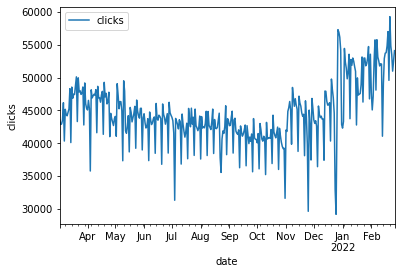

In [14]:
validation = pd.read_csv(confirmation_set, index_col=0, usecols=[columntime, columnname])
print(validation.head())

validation.index = pd.to_datetime(validation.index)
print('Dataset %s, Validation %d' % (len(series), len(validation)))

validation.plot()
plt.ylabel(metric)
plt.xlabel(columntime)
plt.show()

In [15]:
og = series.values
size = int(len(og) * 0.66)
train, test = og[0:size], og[size:len(og)]
history = [x for x in train]
predictions = list()

# fit model
model = sm.tsa.arima.ARIMA(history, order=(4,1,2))
model_fit = model.fit()

print(model_fit.summary())

C:\Users\jessb\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jessb\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  240
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -2230.845
Date:                Mon, 04 Apr 2022   AIC                           4475.691
Time:                        22:37:33   BIC                           4500.026
Sample:                             0   HQIC                          4485.497
                                - 240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4272      0.053     -8.108      0.000      -0.531      -0.324
ar.L2          0.6978      0.038     18.214      0.000       0.623       0.773
ar.L3          0.5723      0.033     17.283      0.0

C:\Users\jessb\python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:
forecast = model_fit.forecast()[0]
print(forecast)

34883.5373958661


In [21]:
validation.index = pd.DatetimeIndex(validation.index).data.to_timestamp()
start_index = 1

end_index = len(series)-1

forecast = model_fit.predict(start=start_index, end=end_index)


history = [x for x in og]
forecastResult = []
numberResult = []
day = 0
last_date = series.index[-1].date()

for yhat in forecast:
    if day < 150:
	#inverted = inverse_difference(history, yhat, days_in_year)
        day_number = timedelta(days=day)
        dtd = last_date + day_number
        a = int(dtd.strftime('%Y%m%d'))
        history.append(yhat)
        print('Day %d:'%(day))
        print("actual")
        print(validation.index[day])
        print(validation[columnname][day])
        print('prediction')
        print('Day %d: %f' % (day, yhat))
        history.append(yhat)
        forecastResult.append(yhat)
        numberResult.append(validation.index[day])
        day += 1

#forecast = model_fit.predict(start=start_index, end=end_index)

# one-step out-of sample forecast
# invert the differenced forecast to something usable
print("forecast result")
print(forecastResult)
d = {dateformat:numberResult, 'Forecast':forecastResult}
histdf = pd.DataFrame(d)
histdf['Forecast'] = pd.to_numeric(histdf['Forecast'])
print(histdf)
print("e")
e = {dateformat:validation.index, 'Validation':validation[columnname]}
validSeriesdf = pd.DataFrame(e)
print(validSeriesdf)
validSeriesdf['Validation'] = pd.to_numeric(validSeriesdf['Validation'])

TypeError: Passing PeriodDtype data is invalid. Use `data.to_timestamp()` instead

                  days  Validation
date                              
2021-03-02  2021-03-02       43558
2021-03-03  2021-03-03       42866
2021-03-04  2021-03-04       42920
2021-03-05  2021-03-05       43496
2021-03-06  2021-03-06       46173
...                ...         ...
2022-02-22  2022-02-22       54858
2022-02-23  2022-02-23       53565
2022-02-24  2022-02-24       50987
2022-02-25  2022-02-25       52644
2022-02-26  2022-02-26       54116

[362 rows x 2 columns]
           days      Forecast
0    2021-03-02  18490.688839
1    2021-03-03  23598.865050
2    2021-03-04  34165.272024
3    2021-03-05  27717.156801
4    2021-03-06  33085.793949
..          ...           ...
145  2021-07-25  40338.677566
146  2021-07-26  39073.403594
147  2021-07-27  40655.452759
148  2021-07-28  39968.715699
149  2021-07-29  42443.095016

[150 rows x 2 columns]


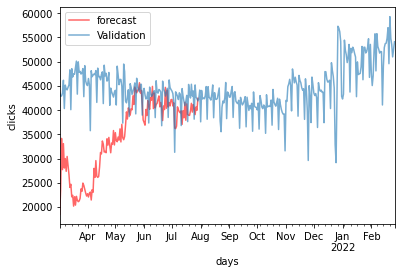

In [22]:
print(validSeriesdf)
print(histdf)

ax = histdf.plot(alpha=0.6, x=dateformat, y="Forecast", label="forecast", color="r")
validSeriesdf.plot(alpha=0.6, x= dateformat, y='Validation', ax = ax)
plt.ylabel(metric)
plt.show()